
---
# Python 人工智能入门 毕业项目
# 为某平台搭建金融风控模型
## 钱雄文
## 2020年4月18日
---


## 目录
<ul>
<li><a href="#definition">定义</a></li>
<li><a href="#analysis">分析</a></li>
<li><a href="#implementation">实现</a></li>
<li><a href="#result">结果</a></li>
<li><a href="#conclusion">结论</a></li>   
</ul>



---
<a id="definition"></a>
## Ⅰ.定义

### 1.项目概况

Lending Club是一家网上个人对个人(P2P)借贷平台。借款人在平台上发布借款需求信息，贷款人在平台上筛选借款需求信息后，向筛选出的借款人发放贷款。之后借款人分期每月向贷款人归还本金与利息，直到还清贷款。在借贷过程中，可能发生借款人最终无法及时履约全额偿还贷款的情况，造成贷款人的损失。因此需要开发有效的方法，预先评估借款人按时全额履约还款的可能性，作为给贷款人决定是否放款的依据。


### 2.问题陈述


在此项目中，我们将通过logistic回归对借款人的基本信息、交易信息等数据进行甄别，预测借款人是否会按时全额还款，作为给贷款人的参考，减少贷款人的损失。

### 3.评价指标

在此项目中，会使用混淆矩阵(confusion matrix)对logistic回归的效果进行评估。计算准确率(precision)和召回率(recall).

---
<a id="analysis"></a>
## Ⅱ.分析


### 1.数据的探索

首先，读入数据：

In [2]:
import pandas as pd
df_original = pd.read_csv('../lending-club-loan-data/loan.csv')

D:\Users\XQIAN\Anaconda3\envs\udacity\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_original.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


查看数据的数量：

In [4]:
df_original.shape

(887379, 74)

可见原始数据有887379行记录，有74列。

接着使用info()函数查看数据类型：

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

查看各列是否有缺失数据：

In [6]:
pd.set_option('max_row',100)
isnull_result = df_original.isnull().any()
isnull_result[isnull_result>0]

emp_title                      True
emp_length                     True
annual_inc                     True
desc                           True
title                          True
delinq_2yrs                    True
earliest_cr_line               True
inq_last_6mths                 True
mths_since_last_delinq         True
mths_since_last_record         True
open_acc                       True
pub_rec                        True
revol_util                     True
total_acc                      True
last_pymnt_d                   True
next_pymnt_d                   True
last_credit_pull_d             True
collections_12_mths_ex_med     True
mths_since_last_major_derog    True
annual_inc_joint               True
dti_joint                      True
verification_status_joint      True
acc_now_delinq                 True
tot_coll_amt                   True
tot_cur_bal                    True
open_acc_6m                    True
open_il_6m                     True
open_il_12m                 

有相当多的列存在空值，可能会对模型构建产生影响，需要预处理。

检查是否有重复的记录：

In [7]:
df_original.duplicated().any()

False

没有重复的记录。

使用describe()查看数值变量的统计参数：

In [8]:
df_original.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,8.873790e+05,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,...,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171030e+05,21372.000000,21372.000000,21372.000000
mean,3.246513e+07,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,18.157039,0.314442,...,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206862e+04,0.943945,1.537058,1.977307
std,2.282734e+07,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,17.190626,0.862244,...,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749826e+04,1.446872,2.723339,2.874067
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,9.206643e+06,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,4.500000e+04,11.910000,0.000000,...,10251.500000,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000
50%,3.443327e+07,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.500000e+04,17.650000,0.000000,...,24684.500000,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.000000,0.000000,2.000000
75%,5.490814e+07,5.847135e+07,20000.000000,20000.000000,20000.000000,16.200000,572.600000,9.000000e+04,23.950000,0.000000,...,47858.000000,87.600000,2.000000,4.000000,7771.500000,75.200000,3.980000e+04,1.000000,2.000000,3.000000
max,6.861706e+07,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,9999.000000,39.000000,...,878459.000000,223.300000,22.000000,43.000000,127305.000000,151.400000,9.999999e+06,17.000000,35.000000,32.000000


### 2.探索性可视化

首先，导入一些画图需要的软件包。

In [9]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

查看数据中的loan_status，包含哪几种status，各有多少条记录？

In [10]:
df_original['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

可见大多数记录仍然处于Current状态。处于Current状态的借款可能最终全额还款，也可能最终不会全额还款，因此对于建立预测模型意义不大。需要将这部分数据过滤掉。

In [11]:
df_no_current = df_original[df_original['loan_status']!='Current']
df_no_current.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_no_current['loan_status'].value_counts()

Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

由于预测模型只关心是否完全还款，即Fully Paid，因此新建一列is_fully_paid

In [13]:
df_no_current['is_fully_paid'] = (df_no_current['loan_status'] == 'Fully Paid')
df_no_current[['loan_status', 'is_fully_paid']].head()

<ipython-input-13-f9cdef7a4354>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_current['is_fully_paid'] = (df_no_current['loan_status'] == 'Fully Paid')


,loan_status,is_fully_paid
0,Fully Paid,True
1,Charged Off,False
2,Fully Paid,True
3,Fully Paid,True
5,Fully Paid,True


提供的数据中，有对用户的分级，即grade列。那不同grade中is_fully_paid的比例是否有所不同？

In [14]:
result_grade = df_no_current.groupby('grade')['is_fully_paid'].mean()
result_grade

grade
A    0.884113
B    0.803696
C    0.705336
D    0.631229
E    0.546777
F    0.499736
G    0.444876
Name: is_fully_paid, dtype: float64

Text(0.5, 1.0, 'Fully Paid Proportion vs Grade')

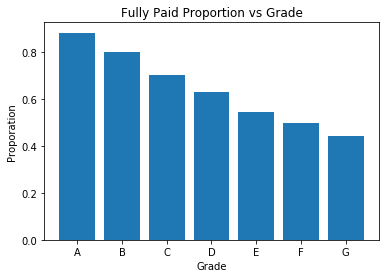

In [15]:
plt.bar(result_grade.index, result_grade)
plt.xlabel('Grade')
plt.ylabel('Proporation')
plt.title('Fully Paid Proportion vs Grade')

可见从A到G，Fully Paid的比例依次递减。

接下来，为了分析的方便，将df_no_current按照is_fully_paid保存为两个dataframe:

In [16]:
df_positive = df_no_current[df_no_current['is_fully_paid'] == True]
df_positive.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,is_fully_paid
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
7,1072053,1288686,3000.0,3000.0,3000.0,36 months,18.64,109.43,E,E1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [17]:
df_negative = df_no_current[df_no_current['is_fully_paid'] == False]
df_negative.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,is_fully_paid
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
8,1071795,1306957,5600.0,5600.0,5600.0,60 months,21.28,152.39,F,F2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9,1071570,1306721,5375.0,5375.0,5350.0,60 months,12.69,121.45,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
12,1064687,1298717,9000.0,9000.0,9000.0,36 months,13.49,305.38,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
14,1069057,1303503,10000.0,10000.0,10000.0,36 months,10.65,325.74,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


计算loan_amnt对于is_fully_paid的平均:

In [18]:
df_no_current.groupby('is_fully_paid')['loan_amnt'].mean()

is_fully_paid
False    14753.06509
True     13346.35091
Name: loan_amnt, dtype: float64

画直方图比较:

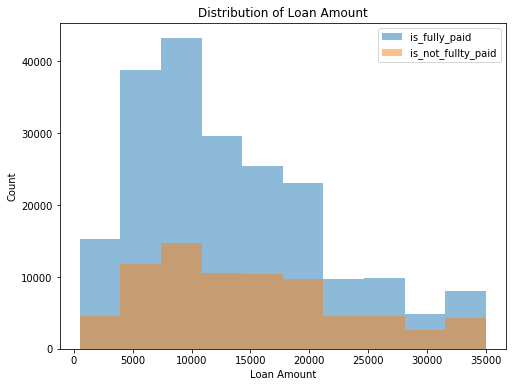

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_positive['loan_amnt'], alpha=0.5, label='is_fully_paid')
ax.hist(df_negative['loan_amnt'], alpha=0.5, label='is_not_fullty_paid')
ax.set_title('Distribution of Loan Amount')
ax.set_xlabel('Loan Amount')
ax.set_ylabel('Count')
ax.legend(loc='upper right')
plt.show()

直方图统计的是个数，由于is_fully_paid和is_not_fully_paid本身样本个数不同，直接比较直方图不是很直观。更改y轴显示为落在直方图各区间内的比例。

In [20]:
from matplotlib.ticker import FuncFormatter
def to_percent(y, position):
    return str(round(100*y)) + "%"

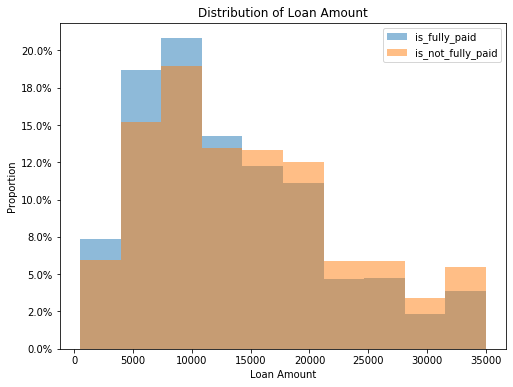

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
data_pos = df_positive['loan_amnt']
data_neg = df_negative['loan_amnt']
ax.hist(data_pos, alpha=0.5, label='is_fully_paid', weights=[1./len(data_pos)]*len(data_pos))
ax.hist(data_neg, alpha=0.5, label='is_not_fully_paid', weights=[1./len(data_neg)]*len(data_neg))
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
ax.set_title('Distribution of Loan Amount')
ax.set_xlabel('Loan Amount')
ax.set_ylabel('Proportion')
ax.legend(loc='upper right')
plt.show()

可见is_not_fully_paid的借款人倾向于借更多的钱。

类似地，可视化installment和int_rate的分布

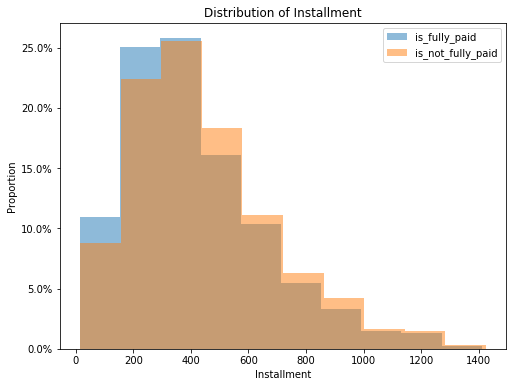

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
data_pos = df_positive['installment']
data_neg = df_negative['installment']
ax.hist(data_pos, alpha=0.5, label='is_fully_paid', weights=[1./len(data_pos)]*len(data_pos))
ax.hist(data_neg, alpha=0.5, label='is_not_fully_paid', weights=[1./len(data_neg)]*len(data_neg))
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
ax.set_title('Distribution of Installment')
ax.set_xlabel('Installment')
ax.set_ylabel('Proportion')
ax.legend(loc='upper right')
plt.show()

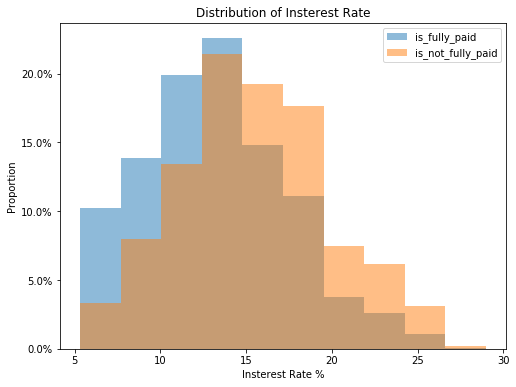

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
data_pos = df_positive['int_rate']
data_neg = df_negative['int_rate']
ax.hist(data_pos, alpha=0.5, label='is_fully_paid', weights=[1./len(data_pos)]*len(data_pos))
ax.hist(data_neg, alpha=0.5, label='is_not_fully_paid', weights=[1./len(data_neg)]*len(data_neg))
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
ax.set_title('Distribution of Insterest Rate')
ax.set_xlabel('Insterest Rate %')
ax.set_ylabel('Proportion')
ax.legend(loc='upper right')
plt.show()

利率高明显风险大。

接下来，计算不同term中is_fully_paid的比例:

In [24]:
df_no_current['term'].value_counts()

 36 months    218277
 60 months     67323
Name: term, dtype: int64

可见term只有两种，36 months和60 months。

In [25]:
result_term = df_no_current.groupby('term')['is_fully_paid'].mean()
result_term

term
 36 months    0.767717
 60 months    0.596349
Name: is_fully_paid, dtype: float64

Text(0.5, 1.0, 'Fully Paid Proporation vs Term')

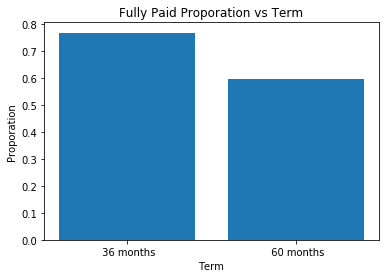

In [26]:
plt.bar(result_term.index, result_term)
plt.xlabel('Term')
plt.ylabel('Proporation')
plt.title('Fully Paid Proporation vs Term')

可见，Term是36 months的Fully Paid比例相比60 months高大约四分之一。

### 3.算法和技术

本项目使用logistic回归算法建立模型对借款人是否会全额按时还款进行预测。使用logistic模型的输入变量为loan_amnt, int_rate, term和grade（installment与loan_amnt线性相关，所以不包括在输入变量内），输出结果为借款人is_fully_paid的概率。

使用logistic模型的优点是，模型运行完毕后，可以得到变量作用是否显著的相关统计结果，根据结果可以对变量进行调整。这是我的第一个机器学习项目，课程目前还未学习其它适用于该问题的算法。

---
<a id="implementation"></a>
## Ⅲ. 实现

### 1.数据预处理

将特征变量和响应变量提取保存在df_model中，并加入截距intercept。

In [27]:
df_model = df_no_current[['loan_amnt', 'int_rate', 'term', 'grade', 'is_fully_paid']]
df_model['intercept'] = 1
df_model.head()

<ipython-input-27-bc1fb8db34a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['intercept'] = 1


,loan_amnt,int_rate,term,grade,is_fully_paid,intercept
0,5000.0,10.65,36 months,B,True,1
1,2500.0,15.27,60 months,C,False,1
2,2400.0,15.96,36 months,C,True,1
3,10000.0,13.49,36 months,C,True,1
5,5000.0,7.90,36 months,A,True,1


将term和grade转换为dummy variables。

In [28]:
df_model[['36 months', '60 months']]=pd.get_dummies(df_model['term'])
df_model.head()

D:\Users\XQIAN\Anaconda3\envs\udacity\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,loan_amnt,int_rate,term,grade,is_fully_paid,intercept,36 months,60 months
0,5000.0,10.65,36 months,B,True,1,1,0
1,2500.0,15.27,60 months,C,False,1,0,1
2,2400.0,15.96,36 months,C,True,1,1,0
3,10000.0,13.49,36 months,C,True,1,1,0
5,5000.0,7.90,36 months,A,True,1,1,0


In [29]:
df_model[['grade_A','grade_B','grade_C','grade_D','grade_E','grade_F','grade_G']] = pd.get_dummies(df_model['grade'])
df_model.head()

D:\Users\XQIAN\Anaconda3\envs\udacity\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,loan_amnt,int_rate,term,grade,is_fully_paid,intercept,36 months,60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,5000.0,10.65,36 months,B,True,1,1,0,0,1,0,0,0,0,0
1,2500.0,15.27,60 months,C,False,1,0,1,0,0,1,0,0,0,0
2,2400.0,15.96,36 months,C,True,1,1,0,0,0,1,0,0,0,0
3,10000.0,13.49,36 months,C,True,1,1,0,0,0,1,0,0,0,0
5,5000.0,7.90,36 months,A,True,1,1,0,1,0,0,0,0,0,0


### 2.执行过程

调用statsmodels包训练模型，并检查统计结果。

In [30]:
import statsmodels.api as sm

In [31]:
logit_mod = sm.Logit(df_model['is_fully_paid'], df_model[['intercept', 'loan_amnt', 'int_rate', '36 months', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.551891
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          is_fully_paid   No. Observations:               285600
Model:                          Logit   Df Residuals:                   285590
Method:                           MLE   Df Model:                            9
Date:                Sat, 18 Apr 2020   Pseudo R-squ.:                 0.05805
Time:                        15:59:48   Log-Likelihood:            -1.5762e+05
converged:                       True   LL-Null:                   -1.6733e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9601      0.086    -22.679      0.000      -2.129      -1.791
loan_amnt  -3.033e-06   5.72e-07     -5.303      0.000   -4.15e-06   -1.91e-06
int_rate       0.0707      0.003     22.991      0.000       0.065       0.077
36 months      0.3003      0.012     25.982      0.000       0.278       0.323
grade_A        3.2088      0.068     46.985      0.000       3.075       3.343
grade_B        2.3296      0.058     40.093      0.000       2.216       2.443
grade_C        1.6243      0.052     31.455      0.000       1.523       1.726
grade_D        1.1125      0.047     23.731      0.000       1.021       1.204
grade_E        0.6639      0.044     14.998      0.000       0.577       0.751
grade_F        0.3019      0.045      6.703      0.000       0.214       0.390
==============================================================================
"""

coef的符号与探索性数据分析的结果相同。P值说明选取的特征变量对预测is_fully_paid有显著的作用。

接下来，使用sklearn将数据随机分为数据集和训练集，进行训练和测试。

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

In [33]:
y = df_model['is_fully_paid']
X = df_model[['loan_amnt', 'int_rate', '36 months', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
log_mod = LogisticRegression()
log_mod.fit(X_train, y_train)
y_preds = log_mod.predict(X_test)
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(accuracy_score(y_test, y_preds))
confusion_matrix(y_test, y_preds)

0.7373906330416881
0.9659066284641129
0.7250875350140056


array([[ 1300, 14287],
       [ 1416, 40117]], dtype=int64)

从结果上看，recall很高，但precision和accuracy有待改善。

### 3.完善

为了提高precsion，尝试引入更多有关借款人方面的信息，比如dti，即负债与收入的比例。

In [35]:
df_model_2 = df_no_current[['loan_amnt', 'int_rate', 'term', 'grade', 'is_fully_paid', 'dti']]
df_model_2.head()

,loan_amnt,int_rate,term,grade,is_fully_paid,dti
0,5000.0,10.65,36 months,B,True,27.65
1,2500.0,15.27,60 months,C,False,1.00
2,2400.0,15.96,36 months,C,True,8.72
3,10000.0,13.49,36 months,C,True,20.00
5,5000.0,7.90,36 months,A,True,11.20


In [36]:
df_model_2[['grade_A','grade_B','grade_C','grade_D','grade_E','grade_F','grade_G']] = pd.get_dummies(df_model_2['grade'])
df_model_2.head()

D:\Users\XQIAN\Anaconda3\envs\udacity\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,loan_amnt,int_rate,term,grade,is_fully_paid,dti,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,5000.0,10.65,36 months,B,True,27.65,0,1,0,0,0,0,0
1,2500.0,15.27,60 months,C,False,1.00,0,0,1,0,0,0,0
2,2400.0,15.96,36 months,C,True,8.72,0,0,1,0,0,0,0
3,10000.0,13.49,36 months,C,True,20.00,0,0,1,0,0,0,0
5,5000.0,7.90,36 months,A,True,11.20,1,0,0,0,0,0,0


In [37]:
df_model_2[['36 months', '60 months']]=pd.get_dummies(df_model_2['term'])
df_model_2.head()

D:\Users\XQIAN\Anaconda3\envs\udacity\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,loan_amnt,int_rate,term,grade,is_fully_paid,dti,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,36 months,60 months
0,5000.0,10.65,36 months,B,True,27.65,0,1,0,0,0,0,0,1,0
1,2500.0,15.27,60 months,C,False,1.00,0,0,1,0,0,0,0,0,1
2,2400.0,15.96,36 months,C,True,8.72,0,0,1,0,0,0,0,1,0
3,10000.0,13.49,36 months,C,True,20.00,0,0,1,0,0,0,0,1,0
5,5000.0,7.90,36 months,A,True,11.20,1,0,0,0,0,0,0,1,0


In [38]:
y_2 = df_model_2['is_fully_paid']
X_2 = df_model_2[['loan_amnt', 'int_rate', '36 months', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'dti']]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.2, random_state = 42)

In [39]:
log_mod_2 = LogisticRegression()
log_mod_2.fit(X_train_2, y_train_2)
y_preds_2 = log_mod_2.predict(X_test_2)
print(precision_score(y_test_2, y_preds_2))
print(recall_score(y_test_2, y_preds_2))
print(accuracy_score(y_test_2, y_preds_2))
confusion_matrix(y_test_2, y_preds_2)

0.7455461613950328
0.9511713577155515
0.7284488795518207


array([[ 2104, 13483],
       [ 2028, 39505]], dtype=int64)

加入dti后，precision有略微提升。

---
<a id="result"></a>
## IV. 结果

### 模型的评价与验证

- 模型的结果基本是合理的。从statsmodels训练出的模型的参数符号与业务的理解是一致的。

- 模型对于这个问题基本是可靠的。通过修改train_test_split中random_state的值可以得到不同的训练集和测试集，结果基本是一致的。模型对于这个问题基本是可靠的。

- 通过修改train_test_split中random_state的值可以得到不同的训练集和测试集，结果基本是一致的。

---
<a id="conclusion"></a>
## V. 项目结论

### 结果可视化


由模型的构建过程和结果可以看出，dti即负债与收入比是一个富有参考意义的变量，因此对dti进行进一步的可视化分析。

In [40]:
df_positive['dti'].describe()

count    207723.000000
mean         16.139156
std           7.696190
min           0.000000
25%          10.420000
50%          15.750000
75%          21.480000
max          57.140000
Name: dti, dtype: float64

In [41]:
df_negative['dti'].describe()

count    77877.000000
mean        18.711710
std          8.245498
min          0.000000
25%         12.650000
50%         18.540000
75%         24.540000
max        136.970000
Name: dti, dtype: float64

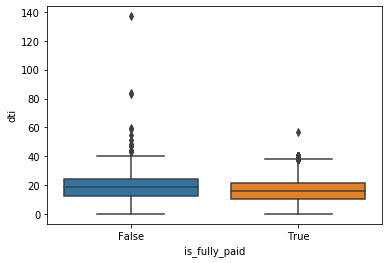

In [42]:
sb.boxplot(data = df_no_current, x = 'is_fully_paid', y = 'dti')

从箱线图可以看出，当dti异常高时（比如超过60时），可以认为借款人几乎一定不会按时全额还款。

### 对项目的思考

在本项目中，基于Lending Club的数据，构建了预测借款者是否会按时全额还款的模型，为贷款人提供参考。项目从问题定义开始，对数据进行了分析和探索性可视化，基于logistic回归构建了模型，并对模型进行了评价与验证。

这是我的第一个机器学习的项目，一切都很新鲜。数据可视化很有意思，通过数据直观的呈现，数据的特征得以方便地被理解，数据从数字转换成了可视化的信息。比较困难的地方在于提高模型的precision。试了一些方法，但因为初学，掌握的方法有限，还有改进的空间。

模型和结果基本可以符合我对问题的期望。对通用的场景可以继续修改模型，解决问题。

### 需要作出的改进

从预测的准确度来看，算法和模型还可以进一步的完善。在学习了人工神经网络之后，或许可以应用在这个项目上，将模型准确度提高到更高的水平。